---

### Import Libraries and Dependencies

In [1]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
import hvplot.pandas
from pathlib import Path
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Fetching Data

In [2]:
#Download stock data
def download_data(tickers, start_date):
    stock_data = yf.download(tickers,start=start_date)
    stock_data = stock_data.drop(columns=["Adj Close", "High", "Low", "Open", "Volume"])
    stock_data["Close"] = stock_data['Close'].astype(float)
    stock_data = stock_data.dropna()
    return stock_data

In [3]:
# Download SPY (SP500) Prices
# SP500_df = download_data(["SPY"], "1980-01-01")
# SP500_df.head()

### Save data as a CSV file

In [4]:
# csv_path = Path("Data/SP500.csv")
# SP500_df .to_csv(csv_path)

### Read in CSV as Pandas DataFrame

In [5]:
#The data has been saved to a csv file so that it doesn't keep updating.
# Set path to CSV and read in CSV
csv_path = Path('Data/SP500.csv')
SP500_df=pd.read_csv(csv_path).set_index("Date")
SP500_df

,Close
Date,
1993-01-29,43.937500
1993-02-01,44.250000
1993-02-02,44.343750
1993-02-03,44.812500
1993-02-04,45.000000
...,...
2020-09-21,326.970001
2020-09-22,330.299988
2020-09-23,322.640015


### Calculate Daily Returns

In [6]:
# Calculate daily percent return
SP500_df['daily_return'] = SP500_df['Close'].pct_change()
SP500_df

,Close,daily_return
Date,,
1993-01-29,43.937500,NaN
1993-02-01,44.250000,0.007112
1993-02-02,44.343750,0.002119
1993-02-03,44.812500,0.010571
1993-02-04,45.000000,0.004184
...,...,...
2020-09-21,326.970001,-0.011130
2020-09-22,330.299988,0.010184
2020-09-23,322.640015,-0.023191


# In this section we will create the Algo trading signals

### Construct Exponential Moving Average of Closing Prices (Trading Signal, Feature One)

In [7]:
# Set short and long windows
short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
SP500_df['fast_close'] = SP500_df['Close'].ewm(halflife=short_window).mean()
SP500_df['slow_close'] = SP500_df['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
SP500_df['crossover_long'] = np.where(SP500_df['fast_close'] > SP500_df['slow_close'], 1.0, 0.0)
SP500_df['crossover_short'] = np.where(SP500_df['fast_close'] < SP500_df['slow_close'], -1.0, 0.0)
SP500_df['crossover_signal'] = SP500_df['crossover_long'] + SP500_df['crossover_short']

SP500_df.head()

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Date,,,,,,,
1993-01-29,43.93750,NaN,43.937500,43.937500,0.0,0.0,0.0
1993-02-01,44.25000,0.007112,44.145833,44.099163,1.0,0.0,1.0
1993-02-02,44.34375,0.002119,44.258929,44.186404,1.0,0.0,1.0
1993-02-03,44.81250,0.010571,44.554167,44.359558,1.0,0.0,1.0
1993-02-04,45.00000,0.004184,44.784274,44.505988,1.0,0.0,1.0


### Plot Exponential Moving Average of Closing Prices

<AxesSubplot:title={'center':'Exponential Moving Average of Closing Prices'}, xlabel='Date'>

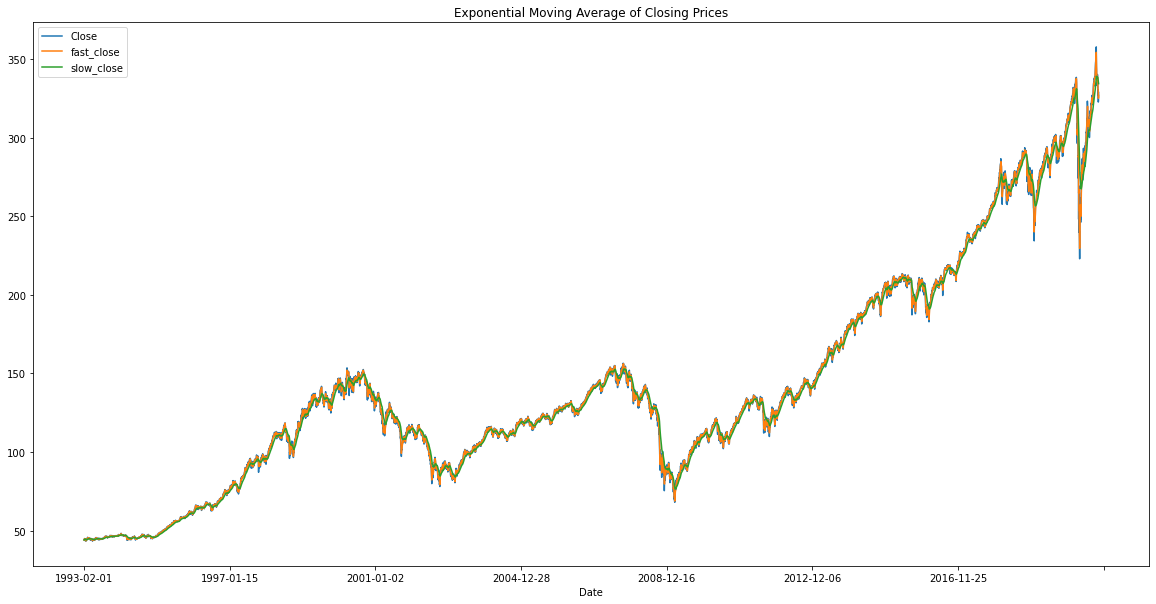

In [44]:
# Plot the EMA of SP500 closing prices
SP500_df[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10),
        title="Exponential Moving Average of Closing Prices")

### Construct Exponential Moving Average of Daily Return Volatility (Trading Signal, Feature Two)

In [9]:
# Set short and long volatility windows
short_vol_window = 1
long_vol_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
SP500_df['fast_vol'] = SP500_df['daily_return'].ewm(halflife=short_vol_window).std()
SP500_df['slow_vol'] = SP500_df['daily_return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
SP500_df['vol_trend_long'] = np.where(SP500_df['fast_vol'] < SP500_df['slow_vol'], 1.0, 0.0)
SP500_df['vol_trend_short'] = np.where(SP500_df['fast_vol'] > SP500_df['slow_vol'], -1.0, 0.0) 
SP500_df['vol_trend_signal'] = SP500_df['vol_trend_long'] + SP500_df['vol_trend_short']

SP500_df

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,,,,,,,,
1993-01-29,43.937500,NaN,43.937500,43.937500,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1993-02-01,44.250000,0.007112,44.145833,44.099163,1.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0
1993-02-02,44.343750,0.002119,44.258929,44.186404,1.0,0.0,1.0,0.003531,0.003531,0.0,0.0,0.0
1993-02-03,44.812500,0.010571,44.554167,44.359558,1.0,0.0,1.0,0.004889,0.004313,0.0,-1.0,-1.0
1993-02-04,45.000000,0.004184,44.784274,44.505988,1.0,0.0,1.0,0.003883,0.003693,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-21,326.970001,-0.011130,330.463733,336.917490,0.0,-1.0,-1.0,0.006609,0.012745,1.0,0.0,1.0
2020-09-22,330.299988,0.010184,330.381860,336.474336,0.0,-1.0,-1.0,0.013486,0.012698,0.0,-1.0,-1.0
2020-09-23,322.640015,-0.023191,326.510937,335.547893,0.0,-1.0,-1.0,0.017033,0.013478,0.0,-1.0,-1.0


### Plot Exponential Moving Average of Daily Return Volatility

<AxesSubplot:title={'center':'Exponential Moving Average of Daily Return Volatility'}, xlabel='Date'>

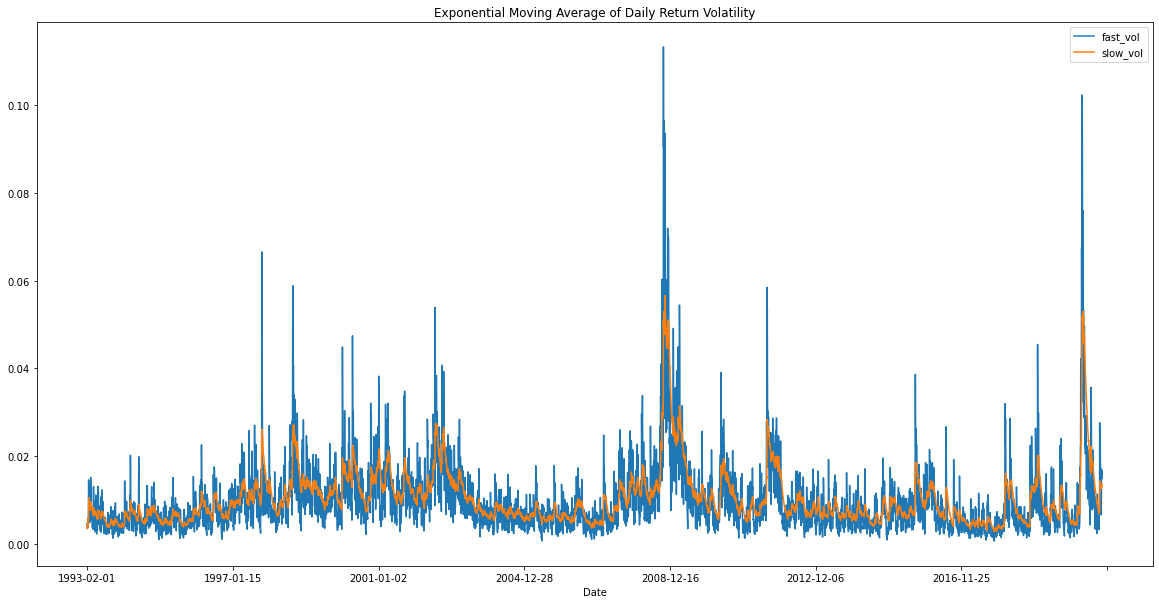

In [45]:
# Plot the EMA of SP500 daily return volatility
SP500_df[['fast_vol', 'slow_vol']].plot(figsize=(20,10),
        title="Exponential Moving Average of Daily Return Volatility")

### Construct Bollinger Band (Trading Signal, Feature Three)

In [11]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
SP500_df['bollinger_mid_band'] = SP500_df['Close'].rolling(window=bollinger_window).mean()
SP500_df['bollinger_std'] = SP500_df['Close'].rolling(window=bollinger_window).std()
SP500_df
# Calculate upper and lowers bands of bollinger band
SP500_df['bollinger_upper_band']  = SP500_df['bollinger_mid_band'] + (SP500_df['bollinger_std'] * 1)
SP500_df['bollinger_lower_band']  = SP500_df['bollinger_mid_band'] - (SP500_df['bollinger_std'] * 1)

# Calculate bollinger band trading signal
SP500_df['bollinger_long'] = np.where(SP500_df['Close'] < SP500_df['bollinger_lower_band'], 1.0, 0.0)
SP500_df['bollinger_short'] = np.where(SP500_df['Close'] > SP500_df['bollinger_upper_band'], -1.0, 0.0)
SP500_df['bollinger_signal'] = SP500_df['bollinger_long'] + SP500_df['bollinger_short']

SP500_df

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,
1993-01-29,43.937500,NaN,43.937500,43.937500,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1993-02-01,44.250000,0.007112,44.145833,44.099163,1.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1993-02-02,44.343750,0.002119,44.258929,44.186404,1.0,0.0,1.0,0.003531,0.003531,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1993-02-03,44.812500,0.010571,44.554167,44.359558,1.0,0.0,1.0,0.004889,0.004313,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1993-02-04,45.000000,0.004184,44.784274,44.505988,1.0,0.0,1.0,0.003883,0.003693,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-21,326.970001,-0.011130,330.463733,336.917490,0.0,-1.0,-1.0,0.006609,0.012745,1.0,0.0,1.0,341.647502,7.951481,349.598984,333.696021,1.0,0.0,1.0
2020-09-22,330.299988,0.010184,330.381860,336.474336,0.0,-1.0,-1.0,0.013486,0.012698,0.0,-1.0,-1.0,341.016501,8.336599,349.353099,332.679902,1.0,0.0,1.0
2020-09-23,322.640015,-0.023191,326.510937,335.547893,0.0,-1.0,-1.0,0.017033,0.013478,0.0,-1.0,-1.0,339.942502,9.249389,349.191891,330.693113,1.0,0.0,1.0


### Plot Bollinger Bands

<AxesSubplot:title={'center':'Bollinger Bands for SP500 closing prices'}, xlabel='Date'>

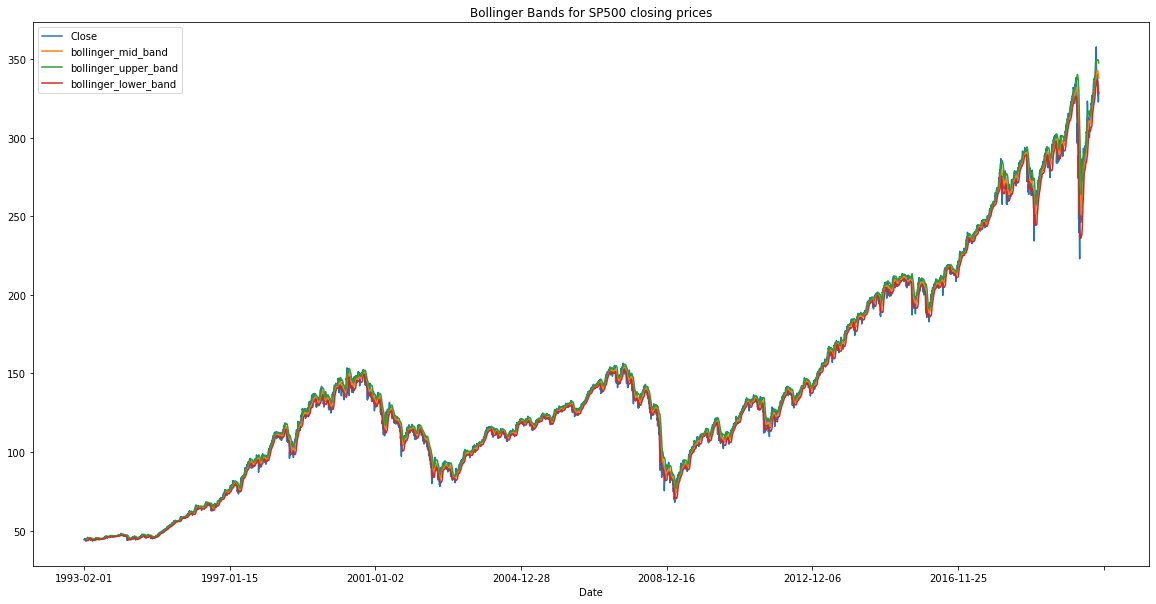

In [47]:
# Plot the Bollinger Bands for SP500 closing prices
SP500_df[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(
    figsize=(20,10),title="Bollinger Bands for SP500 closing prices")

### Set X-Variable List and Filter to Obtain Associated Values

In [13]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal']

# Filter by x-variable list
SP500_df[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-09-21,-1.0,1.0,1.0
2020-09-22,-1.0,-1.0,1.0
2020-09-23,-1.0,-1.0,1.0
2020-09-24,-1.0,-1.0,1.0
2020-09-25,-1.0,-1.0,0.0


### Shift the DataFrame Index by 1

In [14]:
# Shift DataFrame values by 1
SP500_df[x_var_list] = SP500_df[x_var_list].shift(1)
SP500_df[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-09-21,-1.0,1.0,1.0
2020-09-22,-1.0,1.0,1.0
2020-09-23,-1.0,-1.0,1.0
2020-09-24,-1.0,-1.0,1.0
2020-09-25,-1.0,-1.0,1.0


### Drop NAs and Replace Infs (Positive/Negative Infinity)

In [15]:
# Drop NAs and replace positive/negative infinity values
SP500_df.dropna(subset=x_var_list, inplace=True)
SP500_df.dropna(subset=['daily_return'], inplace=True)
SP500_df = SP500_df.replace([np.inf, -np.inf], np.nan)
SP500_df.head()

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,
1993-02-01,44.25000,0.007112,44.145833,44.099163,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1993-02-02,44.34375,0.002119,44.258929,44.186404,1.0,0.0,1.0,0.003531,0.003531,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1993-02-03,44.81250,0.010571,44.554167,44.359558,1.0,0.0,1.0,0.004889,0.004313,0.0,-1.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1993-02-04,45.00000,0.004184,44.784274,44.505988,1.0,0.0,1.0,0.003883,0.003693,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1993-02-05,44.96875,-0.000694,44.877976,44.597069,1.0,0.0,1.0,0.004837,0.004444,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


### Construct the Dependent Variable

In [16]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
SP500_df['Positive Return'] = np.where(SP500_df['daily_return'] > 0, 1.0, 0.0)
SP500_df

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,Positive Return
Date,,,,,,,,,,,,,,,,,,,,
1993-02-01,44.250000,0.007112,44.145833,44.099163,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
1993-02-02,44.343750,0.002119,44.258929,44.186404,1.0,0.0,1.0,0.003531,0.003531,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
1993-02-03,44.812500,0.010571,44.554167,44.359558,1.0,0.0,1.0,0.004889,0.004313,0.0,-1.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
1993-02-04,45.000000,0.004184,44.784274,44.505988,1.0,0.0,1.0,0.003883,0.003693,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
1993-02-05,44.968750,-0.000694,44.877976,44.597069,1.0,0.0,1.0,0.004837,0.004444,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-21,326.970001,-0.011130,330.463733,336.917490,0.0,-1.0,-1.0,0.006609,0.012745,1.0,0.0,1.0,341.647502,7.951481,349.598984,333.696021,1.0,0.0,1.0,0.0
2020-09-22,330.299988,0.010184,330.381860,336.474336,0.0,-1.0,-1.0,0.013486,0.012698,0.0,-1.0,1.0,341.016501,8.336599,349.353099,332.679902,1.0,0.0,1.0,1.0
2020-09-23,322.640015,-0.023191,326.510937,335.547893,0.0,-1.0,-1.0,0.017033,0.013478,0.0,-1.0,-1.0,339.942502,9.249389,349.191891,330.693113,1.0,0.0,1.0,0.0


# In this section we will constrict the model

### Assign Training and Testing Windows

In [17]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(SP500_df))
X_train = SP500_df[: split]
X_test = SP500_df[split:]
y_train = SP500_df['Positive Return'][: split]
y_test = SP500_df['Positive Return'][split:]

#X_train

In [18]:
# Construct training start and end dates
training_start="1993-02-01"
training_end="2012-06-05"

# Construct testing start and end dates
testing_start="2012-06-06"
testing_end="2020-09-25"
    

### Separate X and Y Training Datasets

In [19]:
# Construct the x train and y train datasets
x_train = SP500_df[x_var_list][training_start:training_end]
y_train = SP500_df['Positive Return'][training_start:training_end]

x_train.tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2012-05-30,-1.0,-1.0,0.0
2012-05-31,-1.0,-1.0,0.0
2012-06-01,-1.0,-1.0,0.0
2012-06-04,-1.0,-1.0,1.0
2012-06-05,-1.0,-1.0,1.0



### Separate X and Y Testing Datasets

In [20]:
# Construct the x test and y test datasets
x_test = SP500_df[x_var_list][testing_start:testing_end]
y_test = SP500_df['Positive Return'][testing_start:testing_end]

x_test.tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-09-21,-1.0,1.0,1.0
2020-09-22,-1.0,1.0,1.0
2020-09-23,-1.0,-1.0,1.0
2020-09-24,-1.0,-1.0,1.0
2020-09-25,-1.0,-1.0,1.0


In [21]:
len(x_test), len(y_test)

(2091, 2091)

### Train Random Forest Model

In [22]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model_rfc = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model_rfc.fit(x_train, y_train)

# Make a prediction of "y" values from the x test dataset
predictions_rfc = model_rfc.predict(x_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
results = y_test.to_frame()

#Construict the dataframe
results = pd.DataFrame({ "Actual Value": y_test, "Predicted Value": predictions_rfc})
results .head()

,Actual Value,Predicted Value
Date,,
2012-06-06,1.0,1.0
2012-06-07,1.0,1.0
2012-06-08,1.0,1.0
2012-06-11,0.0,1.0
2012-06-12,1.0,1.0


In [23]:
# Add daily returns and reorder columns
results["Return"] = SP500_df["daily_return"]

results=results[["Return","Actual Value","Predicted Value"]]
results


,Return,Actual Value,Predicted Value
Date,,,
2012-06-06,0.022468,1.0,1.0
2012-06-07,0.000606,1.0,1.0
2012-06-08,0.007952,1.0,1.0
2012-06-11,-0.012697,0.0,1.0
2012-06-12,0.011491,1.0,1.0
...,...,...,...
2020-09-21,-0.011130,0.0,1.0
2020-09-22,0.010184,1.0,1.0
2020-09-23,-0.023191,0.0,1.0


### Plot Predicted Results vs. Actual Results

<AxesSubplot:title={'center':'Predicted Results vs. Actual Results'}, xlabel='Date'>

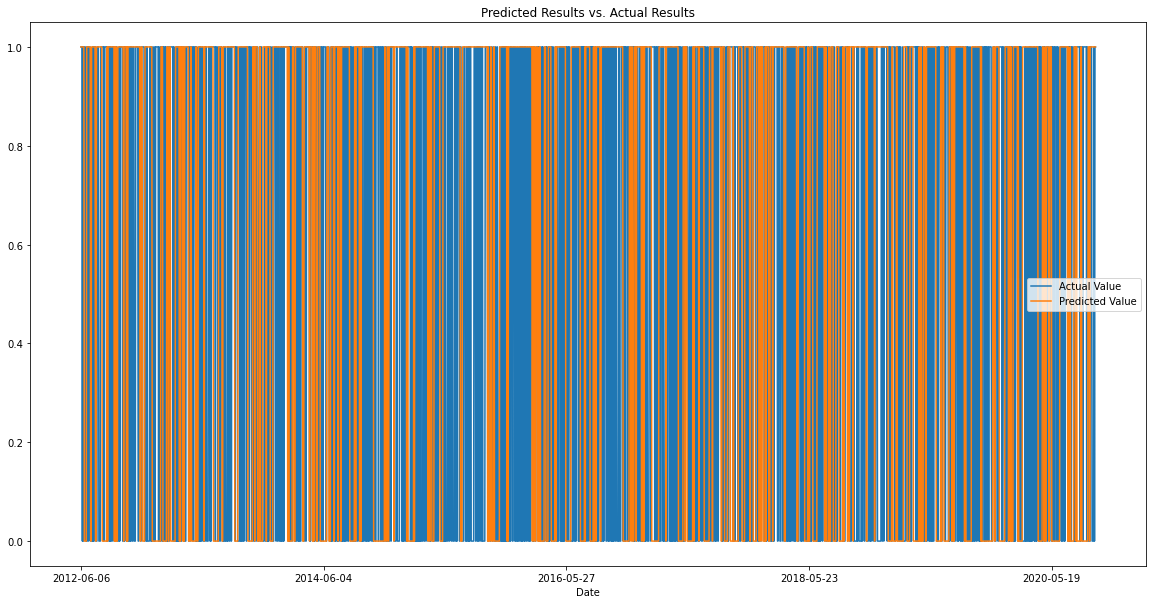

In [49]:
# Plot predicted results vs. actual results
results[['Actual Value', 'Predicted Value']].plot(figsize=(20,10),
        title="Predicted Results vs. Actual Results")

## Plot Predicted Results vs. Actual Results (of last 20 records)

<AxesSubplot:xlabel='Date'>

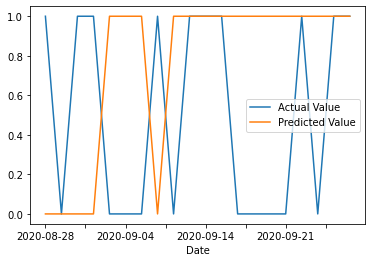

In [25]:
# Plot last 20 records of predicted vs. actual results
results[['Actual Value', 'Predicted Value']].tail(20).plot()

## Evaluate the model

In [26]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions_rfc)

# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions_rfc)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)

#Get classification report
report =classification_report(y_test, predictions_rfc)

In [27]:
# Displaying results
print(f"Accuracy Score : {acc_score}")
print ()
print ()
print("Confusion Matrix")
display(cm_df)
print()
print ()
print("Classification Report")
print(report)




Accuracy Score : 0.5179340028694405


Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,334,595
Actual 1,413,749




Classification Report
              precision    recall  f1-score   support

         0.0       0.45      0.36      0.40       929
         1.0       0.56      0.64      0.60      1162

    accuracy                           0.52      2091
   macro avg       0.50      0.50      0.50      2091
weighted avg       0.51      0.52      0.51      2091



### New evaluation metric

In [28]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, predictions_rfc)

0.004256286893527013

### Plot Cumulative Returns of Random Forest Model

<AxesSubplot:xlabel='Date'>

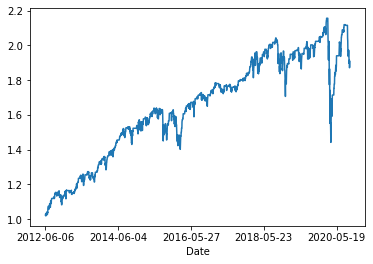

In [29]:
# Calculate cumulative return of model and plot the result
(1 + (results['Return'] * results['Predicted Value'])).cumprod().plot()

## Plot Cumulative Return of Random Forest Model (In Terms of Capital)

<AxesSubplot:title={'center':'Cumulative Return of Random Forest Model'}, xlabel='Date'>

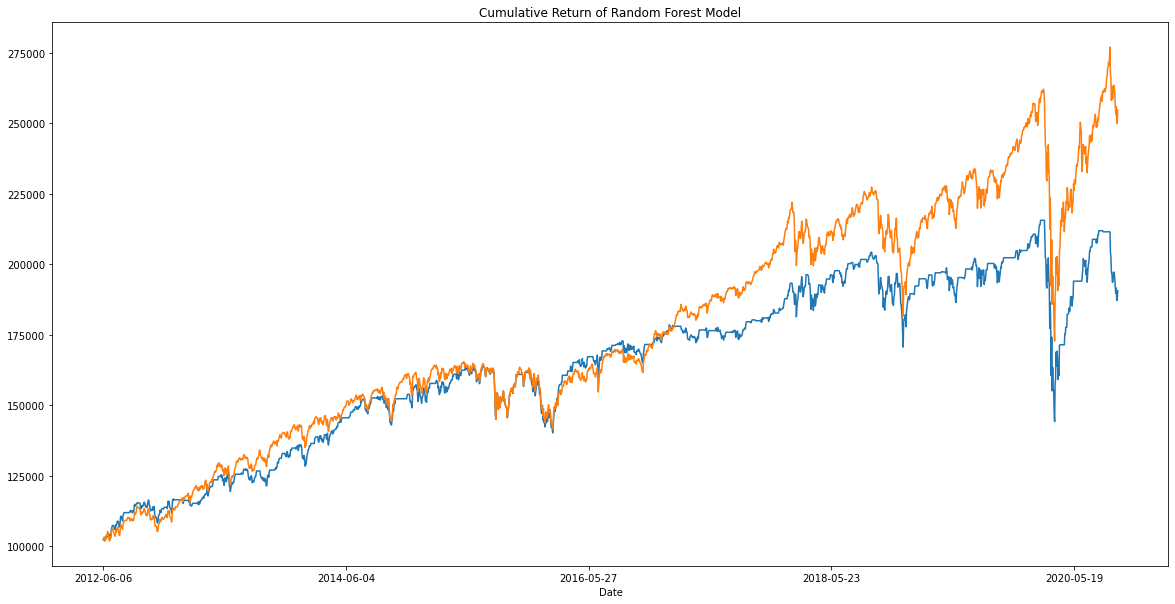

In [51]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (results['Return'] * results['Predicted Value'])).cumprod()
cumulative_return_capital.plot(figsize=(20,10))

# Compare cumulative return of index (SP500)
cumulative_return_index=initial_capital * (1 + (results['Return'])) .cumprod()
cumulative_return_index.plot(figsize=(20,10), title="Cumulative Return of Random Forest Model")                          
                           


# In this section we will use a second model to train the data


### Gradient Boosting Classifier

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

In [32]:
classifier = GradientBoostingClassifier(n_estimators=100,
                                        learning_rate=0.4,
                                       
                                        
                                        random_state=0, 
                                        )

# Fit the model
classifier.fit(x_train, y_train.ravel())

# Make Prediction
predictions_gbc = classifier.predict(x_test)
pd.DataFrame({"Prediction": predictions_gbc, "Actual": y_test.ravel()}).head(20)

,Prediction,Actual
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,0.0
4,1.0,1.0
5,1.0,0.0
6,1.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


In [33]:
# Calculating the accuracy score
acc_score_gbc = accuracy_score(y_test, predictions_gbc)
print(f"Accuracy Score : {acc_score_gbc}")

Accuracy Score : 0.5179340028694405


In [34]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions_gbc)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)

# Displaying results
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,334,595
Actual 1,413,749


In [35]:
# Generate classification report
print("Classification Report")
print(classification_report(y_test, predictions_gbc))

Classification Report
              precision    recall  f1-score   support

         0.0       0.45      0.36      0.40       929
         1.0       0.56      0.64      0.60      1162

    accuracy                           0.52      2091
   macro avg       0.50      0.50      0.50      2091
weighted avg       0.51      0.52      0.51      2091



# In this section we will perform back testing on the Random Forest Results

In [36]:
#Get the predicted results dataframe
results

,Return,Actual Value,Predicted Value
Date,,,
2012-06-06,0.022468,1.0,1.0
2012-06-07,0.000606,1.0,1.0
2012-06-08,0.007952,1.0,1.0
2012-06-11,-0.012697,0.0,1.0
2012-06-12,0.011491,1.0,1.0
...,...,...,...
2020-09-21,-0.011130,0.0,1.0
2020-09-22,0.010184,1.0,1.0
2020-09-23,-0.023191,0.0,1.0


In [37]:
# Include columns for closing prices
results["Close"]=SP500_df["Close"]

# Reorder columns
results= results[["Close","Return", "Actual Value","Predicted Value"]]
results.head()

,Close,Return,Actual Value,Predicted Value
Date,,,,
2012-06-06,131.970001,0.022468,1.0,1.0
2012-06-07,132.050003,0.000606,1.0,1.0
2012-06-08,133.100006,0.007952,1.0,1.0
2012-06-11,131.410004,-0.012697,0.0,1.0
2012-06-12,132.919998,0.011491,1.0,1.0


### Constructing the backtesting dataframe

In [38]:
#Select desired columns
results_df = results[["Close","Predicted Value"]]

results_df.tail(20)

,Close,Predicted Value
Date,,
2020-08-28,350.579987,0.0
2020-08-31,349.309998,0.0
2020-09-01,352.600006,0.0
2020-09-02,357.700012,0.0
2020-09-03,345.390015,1.0
2020-09-04,342.570007,1.0
2020-09-08,333.209991,1.0
2020-09-09,339.790009,0.0
2020-09-10,333.890015,1.0


In [39]:
#Shift up the "Predicted Value" by 1 to create a "signal" column
results_df['Signal'] = results_df["Predicted Value"].shift(-1)
results_df.head()

,Close,Predicted Value,Signal
Date,,,
2012-06-06,131.970001,1.0,1.0
2012-06-07,132.050003,1.0,1.0
2012-06-08,133.100006,1.0,1.0
2012-06-11,131.410004,1.0,1.0
2012-06-12,132.919998,1.0,1.0


In [40]:
# Calculate the points in time at which a position should be taken, 1 or -1
results_df['Entry/Exit'] =results_df["Signal"].diff()

# Print the DataFrame
results_df.head()

,Close,Predicted Value,Signal,Entry/Exit
Date,,,,
2012-06-06,131.970001,1.0,1.0,NaN
2012-06-07,132.050003,1.0,1.0,0.0
2012-06-08,133.100006,1.0,1.0,0.0
2012-06-11,131.410004,1.0,1.0,0.0
2012-06-12,132.919998,1.0,1.0,0.0


### Backtesting the predictions



In [41]:
# Set initial capital
initial_capital = float(100000)

# Set the share size
share_size = 500

# Take a 500 share position where the signal is 1 
results_df['Position'] = share_size * results_df['Signal']

# Find the points in time where a 500 share position is bought or sold
results_df['Entry/Exit Position'] = results_df['Position'].diff()

# Multiply share price by entry/exit positions and get the cumulatively sum
results_df['Portfolio Holdings'] =results_df['Close'] * results_df['Entry/Exit Position'].cumsum()

# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
results_df['Portfolio Cash'] = initial_capital - (results_df['Close'] *results_df['Entry/Exit Position']).cumsum()

# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
results_df['Portfolio Total'] = results_df['Portfolio Cash'] + results_df['Portfolio Holdings']


# Calculate the portfolio daily returns
results_df['Portfolio Daily Returns'] = results_df['Portfolio Total'].pct_change()

# Calculate the cumulative returns
results_df['Portfolio Cumulative Returns'] = (1 + results_df['Portfolio Daily Returns']).cumprod() - 1


# Print the DataFrame
results_df.tail(10)

,Close,Predicted Value,Signal,Entry/Exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,
2020-09-14,338.459991,1.0,1.0,0.0,500.0,0.0,0.0,58035.003662,58035.003662,0.0,-0.41965
2020-09-15,340.170013,1.0,1.0,0.0,500.0,0.0,0.0,58035.003662,58035.003662,0.0,-0.41965
2020-09-16,338.820007,1.0,1.0,0.0,500.0,0.0,0.0,58035.003662,58035.003662,0.0,-0.41965
2020-09-17,335.839996,1.0,1.0,0.0,500.0,0.0,0.0,58035.003662,58035.003662,0.0,-0.41965
2020-09-18,330.649994,1.0,1.0,0.0,500.0,0.0,0.0,58035.003662,58035.003662,0.0,-0.41965
2020-09-21,326.970001,1.0,1.0,0.0,500.0,0.0,0.0,58035.003662,58035.003662,0.0,-0.41965
2020-09-22,330.299988,1.0,1.0,0.0,500.0,0.0,0.0,58035.003662,58035.003662,0.0,-0.41965
2020-09-23,322.640015,1.0,1.0,0.0,500.0,0.0,0.0,58035.003662,58035.003662,0.0,-0.41965
2020-09-24,323.500000,1.0,1.0,0.0,500.0,0.0,0.0,58035.003662,58035.003662,0.0,-0.41965


### Plot Entry and Exit Points of Backtest Results

In [63]:
# Visualize exit position relative to total portfolio value
exit = results_df[results_df['Entry/Exit'] == -1.0]['Portfolio Total'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize entry position relative to total portfolio value
entry = results_df[results_df['Entry/Exit'] == 1.0]['Portfolio Total'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize total portoflio value for the investment
total_portfolio_value = results_df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Overlay plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(xaxis=None, title="Enty/Exit Points")

:Overlay
   .Curve.I                    :Curve   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [Date]   (Portfolio Total)